In [103]:
# 必要最低限
import numpy as np
import mnist
import matplotlib.pyplot as plt
from pylab import cm

X = mnist.download_and_parse_mnist_file("train-images-idx3-ubyte.gz")
Y = mnist.download_and_parse_mnist_file("train-labels-idx1-ubyte.gz") 

#入力層のクラス
class InputLayer:
    def __init__(self, x):
        self.x = x
    def output(self):
        return self.x
    
# 畳み込み層のクラス
class ConvolutionLayer:
    def __init__(self, x, filter_mateix, bias, batch, R, s, p):
        self.x = x #batch * ch * dx * dy行列
        self.filter_matrix = filter_mateix #フィルター行列だが、R*Rではない。フィルター行列の集合
        self.bias = bias #バイアス
        self.batch = batch #バッチサイズ
        self.R = R #フィルターサイズ
        self.s = s #ストライド
        self.p = p #パディングサイズ
    def padding(self):
        batch, ch, dx, dy = self.x.shape
        r = int(int(self.R/2) * self.p)
        padding = np.zeros((batch, ch, dx + 2*r, dy + 2*r)) 
        # print(f'{padding.shape=}')
        padding[:, :, r:(dx+r), r:(dy+r)] = self.x
        # print(f'{padding.shape=}')
        return padding
    def rerange(self):
        batch, ch, dx, dy = self.x.shape
        C = self.padding()
        #畳み込み後の行列サイズを計算する
        o = int((dx + 2*self.p - self.R)/self.s)+1
        C = np.lib.stride_tricks.as_strided(C, shape=(batch, ch, o, o, self.R, self.R),\
                                            strides=(C.strides[0], C.strides[1],self.s*C.strides[2], self.s*C.strides[3], C.strides[2], C.strides[3])
                                           )
        C = C.transpose(1, 4, 5, 0, 2, 3).reshape(ch * self.R * self.R, -1)
        return C
    def output(self):
        W = self.filter_matrix
        B = self.bias
        return np.dot(W, self.rerange()) + B[:,np.newaxis]
    def test_output(self):
        W = self.filter_matrix
        B = self.bias
        return np.dot(W, self.rerange()) + B

# Convolutionレイヤの実装
class Convolution:
    
    # インスタンス変数の定義
    def __init__(self, W, b, stride=1, pad=1):
        self.W = W # フィルター(重み)
        self.b = b # バイアス
        self.stride = stride # ストライド
        self.pad = pad # パディング
        
        # (逆伝播時に使用する)中間データを初期化
        self.x = None # 入力データ
        self.col = None # 2次元配列に展開した入力データ
        self.col_W = None # 2次元配列に展開したフィルター(重み)
        
        # 勾配に関する変数を初期化
        self.dW = None # フィルター(重み)に関する勾配
        self.db = None # バイアスに関する勾配
    
    # 順伝播メソッドの定義
    def forward(self, x):
        # 各データに関するサイズを取得
        FN, C, FH, FW = self.W.shape # フィルター
        N, C, H, W = x.shape # 入力データ
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride) # 出力データ:式(7.1)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)
        
        # 各データを2次元配列に展開
        col = im2col(x, FH, FW, self.stride, self.pad) # 入力データ
        col_W = self.W.reshape(FN, -1).T # フィルター
        
        # 出力の計算:(図7-12)
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        # (逆伝播時に使用する)中間データを保存
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    # 逆伝播メソッドの定義
    def backward(self, dout):
        # フィルターに関するサイズを取得
        FN, C, FH, FW = self.W.shape
        
        # 順伝播の入力を展開
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        # 各パラメータの勾配を計算:式(5.13)
        self.db = np.sum(dout, axis=0) # バイアス
        self.dW = np.dot(self.col.T, dout) # (展開した)重み
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW) # 本来の形状に変換
        dcol = np.dot(dout, self.col_W.T) # (展開した)入力データ
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad) # 本来の形状に変換

        return dx
    
# プーリング層のクラス
class PoolingLayer:
    def __init__(self, x, batch, R, s):
        self.x = x #畳み込み層からの入力
        self.batch = batch #バッチサイズ
        self.R = R #プーリング層のサイズ
        self.s = s #ストライド
        self.max_indices = None  # 最大値のインデックスを保持する変数
    def output(self):
        dx, dy = self.x.shape
        newdy = int(np.sqrt(int(dy/self.batch)))
        #これにより batch * K * dx * dy配列に変化
        tensor_x = np.array(np.array_split(self.x, dy // int(dy/self.batch), axis=1)).reshape(self.batch, dx, newdy, newdy)
        #これにpoolingを適用する
        d = self.R
        n, c, h, w = tensor_x.shape
        output_h = (h - d) // self.s + 1 #出力の高さ
        output_w = (w - d) // self.s + 1 #出力の幅
        pooled_data = tensor_x[:, :, :output_h * self.s, :output_w * self.s].reshape(n, c, output_h, d, output_w, d)
        pooled_data = pooled_data.max(axis=(3, 5))
        return pooled_data
    def max_index(self):
        dx, dy = self.x.shape
        newdy = int(np.sqrt(int(dy/self.batch)))
        #これにより batch * K * dx * dy配列に変化
        tensor_x = np.array(np.array_split(self.x, dy // int(dy/self.batch), axis=1)).reshape(self.batch, dx, newdy, newdy)
        #これにpoolingを適用する
        d = self.R
        n, c, h, w = tensor_x.shape
        output_h = (h - d) // self.s + 1 #出力の高さ
        output_w = (w - d) // self.s + 1 #出力の幅
        pooled_data = tensor_x[:, :, :output_h * self.s, :output_w * self.s].reshape(n, c, output_h, d, output_w, d)
        # マックスプーリングのマスクを作成、多分これで、インデックスを保持することができているはず、、、
        mask = (pooled_data == np.max(pooled_data, axis=(3, 5), keepdims=True))
        # mask = np.argwhere(pooled_data == np.max(pooled_data, axis=(3, 5)))
        mask = mask.reshape(n, c, output_h*d, output_w*d).astype(int)
        return mask
    


# 全結合層のクラス
class ConnectionLayer:
    def __init__(self, x, w, b):
        self.x = x
        self.w= w
        self.b = b
    def output(self):
        self.x = np.array(self.x)
        self.w = np.array(self.w)
        self.b = np.array(self.b)
        return np.dot(self.w.T, self.x) + self.b[:, np.newaxis]
    def dot_wx(self):
        self.x = np.array(self.x)
        self.w = np.array(self.w)
        return np.dot(self.w.T, self.x)
    def dot_b(self):
        self.b = np.array(self.b)
        return self.b[:, np.newaxis]
    def test_output(self):
        self.x = np.array(self.x)
        self.w = np.array(self.w)
        self.b = np.array(self.b)
        return np.dot(self.w.T, self.x) + self.b

#中間層のクラス(sigmoid, relu)
class MiddleLayer:
    def __init__(self, x, function):
        self.x = x
        self.function = function
    def output(self):
        return self.function(self.x)
    
# 中間層のクラス（dropout）
class Dropout:
    def __init__(self, rho):
        self.x = None
        self.rho = rho
        self.dropout_matrix = None
        self.del_en_x = None
        self.y = None
    def output(self, x):
        self.x = x
        rows, cols = self.x.shape
        indices = np.arange(rows)
        np.random.shuffle(indices)
        result_matrix = np.copy(self.x)
        for col in range(cols):
            selected_indices = indices[:self.rho]
            result_matrix[selected_indices, col] = 0
        return result_matrix
    #畳み込みの時用のドロップアウト
    def forward(self, x):
        self.x = x
        b, k, d = self.x.shape
        #rhoだけ0で、1-rhoだけ1のk * d行列を生成
        dropout_matrix = np.ones((k, d))
        num_zeros = int(self.rho * k * d)
        indices_to_set_to_zero = np.random.choice(k * d, num_zeros, replace=False)
        row_indices, col_indices = np.unravel_index(indices_to_set_to_zero, (k, d))
        dropout_matrix[row_indices, col_indices] = 0
        self.dropout_matrix = dropout_matrix
        self.y = np.multiply(self.x, dropout_matrix)
        return self.y
    #逆伝播
    def backward(self, del_en_y):
        self.del_en_x = np.multiply(del_en_y, self.dropout_matrix)
        return np.multiply(del_en_y, self.dropout_matrix)
        
        
        
        
# 出力層のクラス
class OutputLayer:
    def __init__(self, x, softmax):
        self.x = x
        self.softmax = softmax
    def output(self):
        return self.softmax(self.x)

# クロスエントロピーを計算するクラス
class CrossEntropy:
    def __init__(self, x, onehot):
        self.x = x
        self.onehot = onehot
    def safelog(self):
        try:
            result = -np.log(self.x)
        except RuntimeWarning as e:
            result = np.where(self.x <= 0, 100, -np.log(self.x))
        return result
    def result(self):
        loglist = self.safelog()
        crossentropy = np.sum(self.onehot * loglist, axis=0)
        batch = loglist.shape[1]
        return np.sum(crossentropy) / batch

# softmaxとクロスエントロピー誤差の逆伝播クラス
class ErrorBackCrossEntropy:
    def __init__(self, x, onehot):
        self.x = x
        self.onehot = onehot
    def del_en_x(self):
        batch = self.x.shape[1]
        return (self.x - self.onehot) / batch
    
# 中間層の逆伝播のクラス
# シグモイド関数の逆伝播のクラス
class ErrorBackSigmoid:
    def __init__(self, y, del_en_y):
        self.y = y
        self.del_en_y = del_en_y
    def del_en_x(self):
        new_y = (1 - self.y) * self.y
        result = self.del_en_y * new_y
        return result
    
# relu関数の逆伝播のクラス
class ErrorBackReLU:
    def __init__(self, y, del_en_y):
        self.y = y
        self.del_en_y = del_en_y
    def del_en_x(self):
        new_y = np.where(self.y > 0, 1, 0)
        result = self.del_en_y * new_y
        return result
    
# dropoutの逆伝播クラス
class ErrorBackDropout:
    def __init__(self, y, del_en_y):
        self.y = y
        self.del_en_y = del_en_y
    def del_en_x(self):
        new_y = np.where(self.y == 0, 0, 1)
        result = self.del_en_y * new_y
        return result
    
#正規化層の誤差逆伝播クラス
class ErrorBackNormalize:
    def __init__(self, x, x_hat, del_en_y, gamma, beta, epsilon, mean, var, batch):
        self.x = x
        self.x_hat = x_hat
        self.del_en_y = del_en_y
        self.gamma = gamma
        self.beta = beta
        self.epsilon = epsilon
        self.mean = mean
        self.var = var
        self.batch = batch
    def del_en_x_hat(self):
        return self.del_en_y * self.gamma[:,np.newaxis]
    def del_en_var(self):
        mult = np.sum(self.del_en_x_hat()*(self.x - self.mean[:, np.newaxis]), axis=1)
        return (-1) / 2 * mult *  np.power((self.var + self.epsilon), -1.5 ) 
    def del_en_mean(self):
        e1 = np.sum(self.del_en_x_hat(), axis=1)  * (-1) / np.sqrt(self.var + self.epsilon)
        e2 = (-2) * self.del_en_var() * (np.sum(self.x, axis=1)/self.batch - self.mean)
        return e1 + e2
    def del_en_x(self):
        e1 = self.del_en_x_hat() / np.sqrt(self.var + self.epsilon)[:,np.newaxis]
        e2 = 2 / self.batch * (self.x - self.mean[:,np.newaxis]) * self.del_en_var()[:,np.newaxis]
        e3 = self.del_en_mean() / self.batch
        return e1 + e2 + e3[:,np.newaxis]
    def del_en_gamma(self):
        return np.sum(self.del_en_y * self.x, axis=1)
    def del_en_beta(self):
        return np.sum(self.del_en_y, axis=1)
    
# 全結合層の逆伝播クラス
class ErrorBackConnect:
    def __init__(self, x, del_en_y, w):
        self.x = x
        self.del_en_y = del_en_y
        self.w = w
    def del_en_x(self):
        return np.dot(self.w, self.del_en_y)
    def del_en_w(self):
        return np.dot(self.del_en_y, self.x.T)
    def del_en_b(self):
        return np.sum(self.del_en_y, axis=1)
    
# プーリング層の誤差逆伝播クラス
class ErrorBackPooling:
    def __init__(self, x, y, del_en_y, K, batch, max_index, R, R_conv):
        self.x = x #プーリング層の入力
        self.y = y #プーリング層の出力
        self.del_en_y = del_en_y
        self.K = K #フィルタ数
        self.batch = batch
        self.max_index = max_index #プーリング層で抽出された要素は1, そうでない要素は0となっている配列
        self.R = R #プーリングのサイズ
        self.R_conv = R_conv
    def reshape_del(self, m):
        self.m = m
        z, batch = self.m.shape
        dx = int(np.sqrt(int(z/self.K)))
        #これにより、batch*K*dx*dx配列に変化
        tensor_del = self.m.T.reshape(batch, self.K, dx, dx)
        return tensor_del
    def reshape_x(self, n):
        self.n = n
        dx, dy = self.n.shape
        newdy = int(np.sqrt(int(dy/self.batch)))
        #これにより batch * K * dx * dy配列に変化
        tensor_x = np.array(np.array_split(self.n, dy // int(dy/self.batch), axis=1)).reshape(self.batch, dx, newdy, newdy)
        #これにpoolingを適用する
        return tensor_x
    #こちらは、pooling層2の誤差逆伝播に限定することにする
    def del_en_x(self):
        del_en_y_reshaped = self.reshape_del(self.del_en_y)
        b, k, dx, dy =  self.reshape_x(self.x).shape
        expanded_del = del_en_y_reshaped.repeat(self.R, axis=2).repeat(self.R, axis=3)
        expanded_del = expanded_del.reshape(b, k, dx, dy)
        C = expanded_del * self.max_index
        return C.transpose(1, 0, 2, 3).reshape(k, -1)
    #こちらはpooling層1の誤差逆伝播に限定
    def del_en_x_sub(self):
        # b, k, dx, dy = self.y.shape
        b, k, h, w = self.reshape_x(self.x).shape
        # expanded_del = self.del_en_y[np.arange(self.del_en_y.shape[0]) % 9 == 4]
        # expanded_del = self.reshape_del(expanded_del)
        # expanded_del = expanded_del.repeat(self.R, axis=2).repeat(self.R, axis=3)
        # expanded_del = expanded_del.reshape(b, k, w, h)
        # dx, dy = self.x.shape
        expanded_del = col2im(self.del_en_y, self.y.shape, 3, 3, 1, 1)
        expanded_del = expanded_del.repeat(self.R, axis=2).repeat(self.R, axis=3)
        expanded_del = expanded_del.reshape(b, k, w, h)
        
        C = expanded_del * self.max_index
        return C.transpose(1, 0, 2, 3).reshape(k, -1)
    
# 畳み込み層の誤差逆伝播クラス
class ErrorBackConvolution:
    def __init__(self, x, del_en_y, w):
        self.x = x
        self.del_en_y = del_en_y
        self.w = w
    def del_en_x(self):
        return np.dot(self.w.T, self.del_en_y)
    def del_en_w(self):
        return np.dot(self.del_en_y, self.x.T)
    def del_en_b(self):
        return np.sum(self.del_en_y, axis=1)
    def del_en_x_sub(self):
        del_y = np.dot(self.w.T, self.del_en_y)
        expanded_del = del_y[np.arange(del_y.shape[0]) % 9 == 4]
        return expanded_del
    
# シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ソフトマックス関数
def softmax(x):
    x = x - np.max(x, axis = 0)
    return np.exp(np.array(x)) / np.sum(np.exp(np.array(x)), axis=0)

# リストの一致率を示す関数
def calculate_similarity(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("リストの長さが異なります")

    # 一致した要素の数を数える
    match_count = sum(1 for a, b in zip(list1, list2) if a == b)

    # 一致率を計算
    similarity = (match_count / len(list1)) * 100  # パーセントで表示

    return similarity

# ReLU関数
def relu(x):
    return np.where(x > 0, x, 0)


# class BatchNormalization:
#     def __init__(self, gamma, beta):
#         self.gamma = gamma
#         self.beta = beta
        
#         self.x = None
#         self.del_en_x = None
#     def forward(self, x):
#         self.x = x
        


平均のクロスエントロピー0.20516436811835156
正解率:97.0
テスト開始


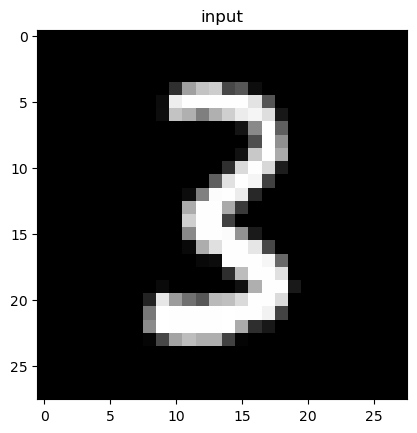

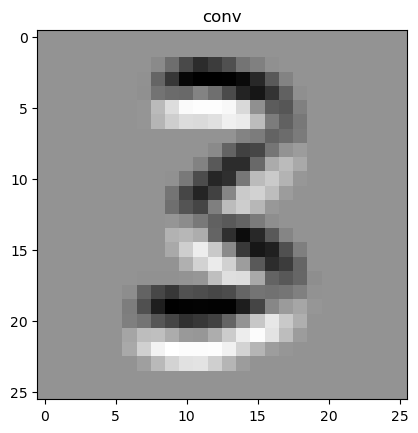

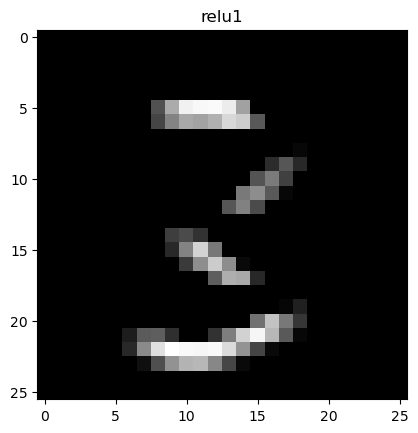

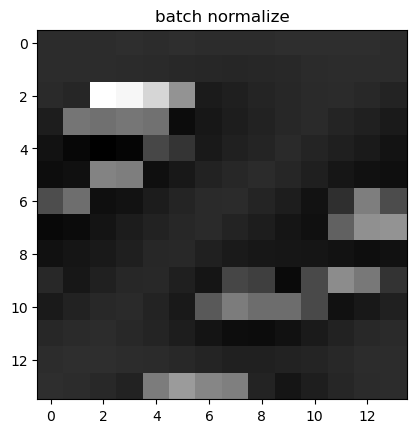

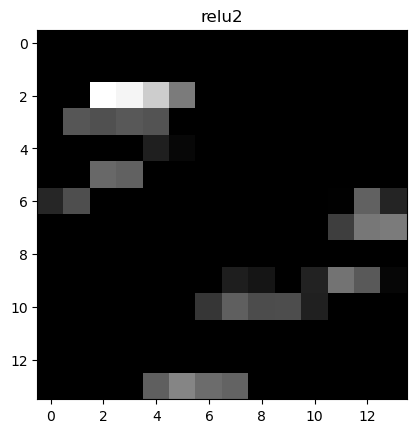

[3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 1, 4, 1, 2, 9, 6, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5, 0, 6, 8, 7, 6, 8, 9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 7, 4, 4, 5, 6, 6, 1, 7, 2, 8, 6, 9, 7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9, 4, 7, 6, 0, 9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7, 9, 9, 6, 7, 3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2, 6, 9, 8, 8, 8, 5, 9, 3, 8, 9, 8, 8, 8, 3, 4, 4, 3, 0, 9, 5, 4, 4, 1, 8, 0, 6, 1, 3, 2, 0, 8, 6, 0, 3, 8, 4, 9, 0, 3, 1, 0, 9, 3, 2, 4, 3, 3, 7, 4, 9, 2, 1, 6, 2, 1, 5, 7, 1, 9, 7, 9, 2, 2, 8, 1, 7, 7, 0, 0, 1, 8, 0, 0, 6, 6, 4, 7, 9, 7, 2, 9, 1, 5, 2, 5, 3, 7, 7, 0, 0, 8, 2, 3, 1, 3, 5, 1, 3, 6, 4, 8, 7, 6, 2, 8, 1, 8, 6, 6, 8, 7, 5, 6, 0, 4, 8, 4, 9, 3, 2, 3, 6, 2, 0, 1, 1, 6, 2, 5, 3, 0, 4, 3, 5, 8, 6, 9, 7, 8, 8, 3, 9, 0, 0, 3, 1, 4, 2, 5, 5, 9, 4, 5, 5, 5, 6, 0, 7, 1, 8, 0, 7, 3, 0, 5, 

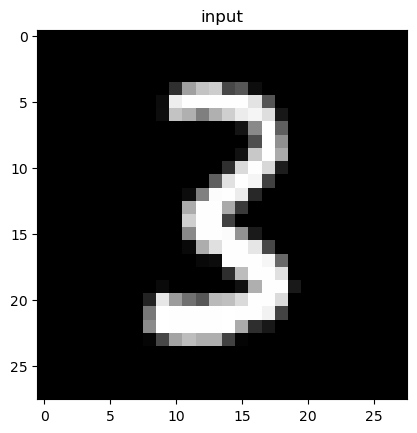

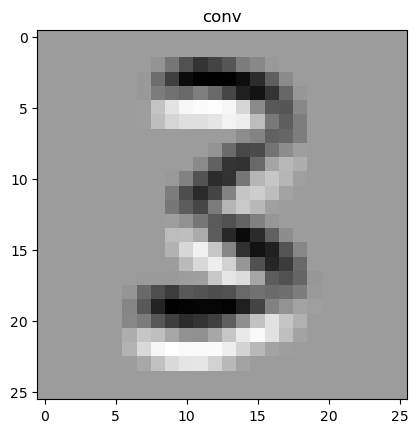

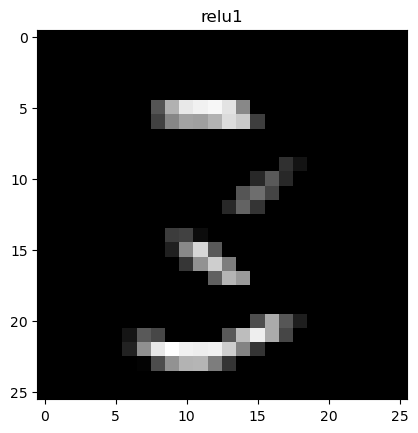

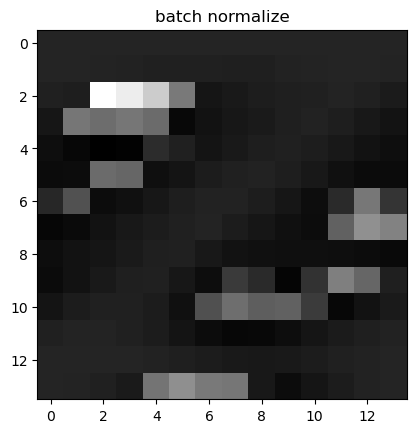

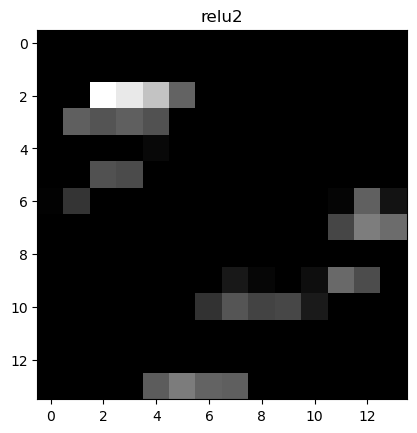

[3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5, 0, 6, 8, 7, 6, 8, 9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 1, 4, 9, 5, 6, 6, 1, 7, 2, 8, 6, 9, 7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9, 4, 7, 6, 0, 9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7, 9, 9, 6, 7, 3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2, 6, 9, 8, 8, 8, 5, 9, 3, 8, 9, 8, 8, 8, 3, 4, 4, 3, 0, 9, 5, 4, 4, 1, 8, 0, 6, 1, 3, 2, 0, 8, 6, 0, 3, 8, 4, 9, 0, 3, 1, 0, 9, 3, 2, 8, 3, 3, 7, 4, 9, 2, 1, 6, 2, 1, 5, 7, 1, 9, 7, 9, 2, 2, 8, 1, 7, 7, 0, 0, 1, 8, 0, 0, 6, 6, 4, 7, 9, 7, 2, 9, 1, 5, 2, 5, 3, 7, 7, 0, 0, 8, 2, 3, 1, 3, 5, 1, 3, 6, 4, 8, 7, 6, 2, 8, 1, 8, 6, 6, 8, 7, 5, 6, 0, 4, 8, 4, 9, 3, 2, 3, 6, 2, 0, 1, 1, 6, 2, 5, 3, 0, 4, 3, 5, 8, 6, 9, 7, 8, 8, 3, 9, 0, 0, 3, 1, 4, 2, 5, 8, 9, 4, 5, 5, 5, 6, 0, 7, 1, 8, 0, 7, 3, 0, 5, 

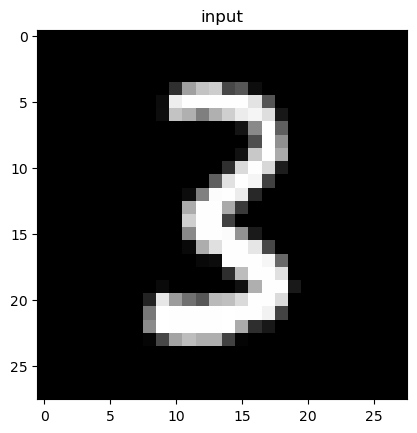

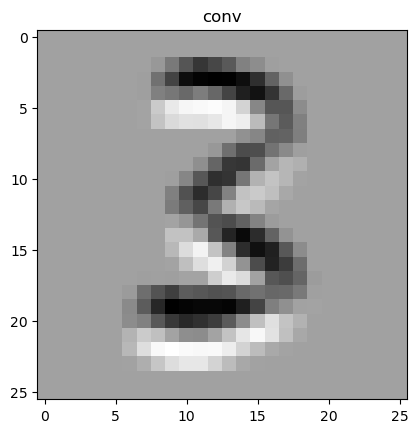

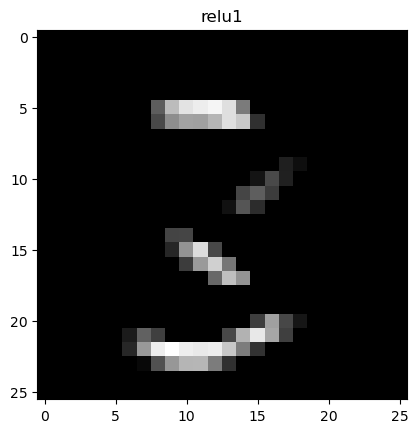

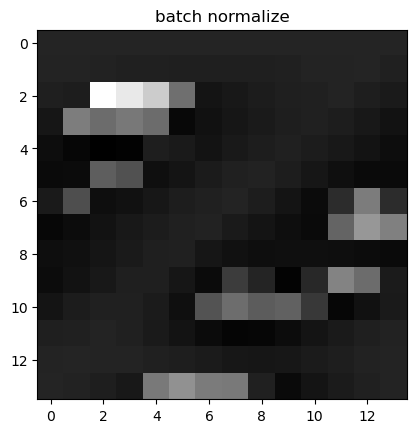

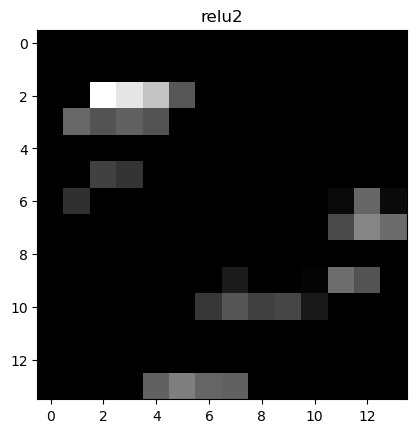

[3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5, 0, 6, 8, 7, 6, 8, 9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 9, 4, 4, 5, 6, 6, 1, 7, 2, 8, 6, 9, 7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9, 4, 7, 6, 0, 9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7, 9, 9, 6, 7, 3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2, 6, 9, 8, 8, 8, 5, 9, 3, 8, 9, 8, 8, 8, 3, 4, 4, 8, 0, 9, 5, 4, 4, 1, 8, 0, 6, 1, 3, 2, 0, 8, 6, 0, 3, 8, 4, 9, 0, 3, 1, 0, 9, 3, 2, 8, 3, 3, 7, 4, 9, 2, 1, 6, 2, 1, 5, 7, 1, 9, 7, 9, 2, 2, 8, 1, 7, 7, 0, 0, 1, 8, 0, 0, 6, 6, 4, 7, 9, 7, 2, 9, 1, 5, 2, 5, 3, 7, 7, 0, 0, 8, 2, 3, 1, 3, 5, 1, 3, 6, 4, 8, 7, 6, 2, 8, 1, 8, 6, 6, 8, 7, 5, 6, 0, 4, 8, 4, 9, 3, 2, 3, 6, 2, 0, 1, 1, 6, 2, 5, 3, 0, 4, 3, 5, 8, 6, 9, 7, 8, 8, 3, 9, 0, 0, 3, 1, 4, 2, 5, 8, 9, 4, 5, 5, 5, 6, 0, 7, 1, 8, 0, 7, 3, 0, 5, 

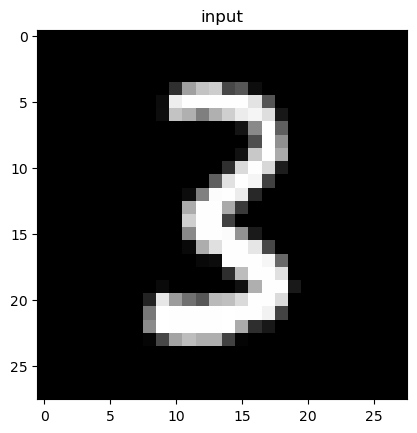

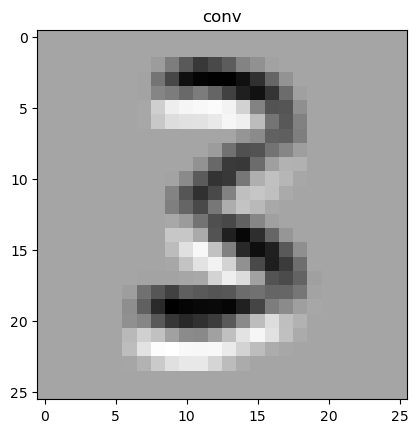

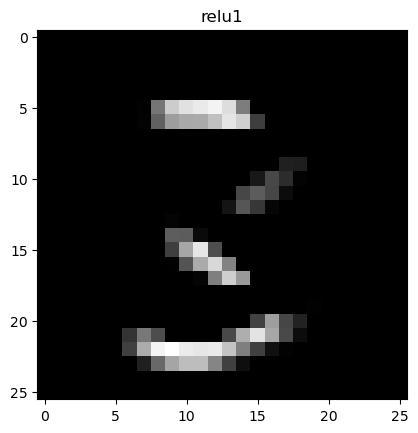

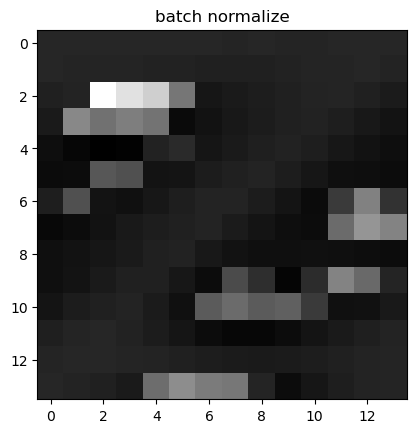

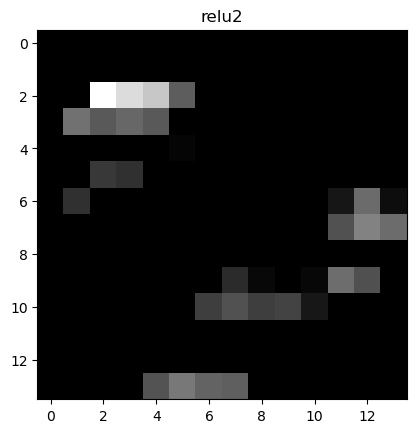

[3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5, 0, 6, 8, 7, 6, 8, 9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 9, 4, 4, 5, 6, 6, 1, 7, 2, 8, 6, 9, 7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9, 7, 7, 6, 0, 9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7, 9, 9, 6, 7, 3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2, 6, 9, 8, 8, 8, 5, 9, 3, 8, 9, 8, 8, 8, 3, 4, 4, 3, 0, 9, 5, 4, 4, 1, 8, 0, 6, 1, 3, 2, 0, 8, 6, 0, 3, 5, 4, 9, 0, 3, 1, 0, 9, 3, 2, 8, 3, 3, 7, 4, 9, 2, 1, 6, 2, 1, 5, 7, 1, 9, 7, 9, 2, 2, 8, 1, 7, 7, 0, 1, 1, 8, 0, 0, 6, 6, 4, 7, 9, 7, 2, 9, 1, 5, 2, 5, 3, 7, 7, 0, 0, 8, 2, 3, 1, 3, 5, 1, 3, 6, 4, 8, 7, 6, 2, 8, 1, 8, 6, 6, 8, 7, 5, 6, 0, 4, 8, 4, 9, 3, 2, 3, 6, 2, 0, 1, 1, 6, 2, 5, 3, 0, 4, 3, 5, 8, 6, 9, 7, 8, 8, 3, 9, 0, 0, 3, 1, 4, 2, 5, 3, 9, 4, 5, 5, 5, 6, 0, 7, 1, 8, 0, 7, 3, 0, 5, 

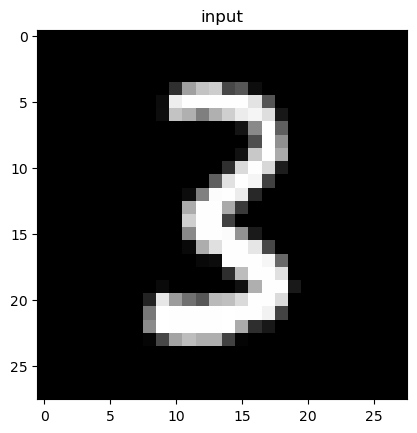

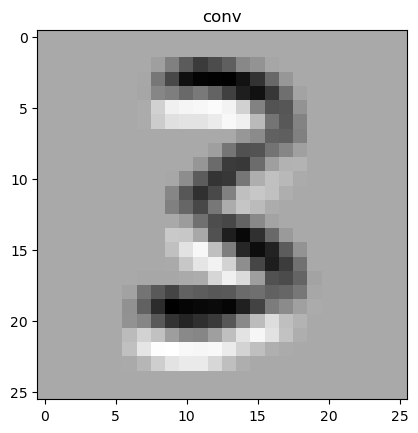

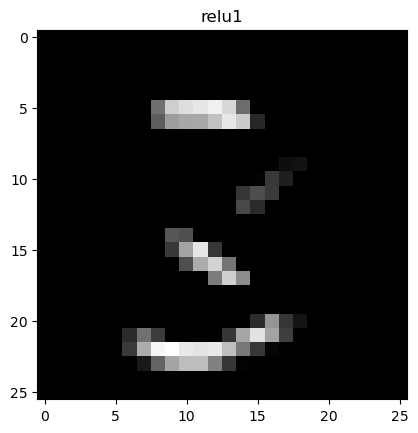

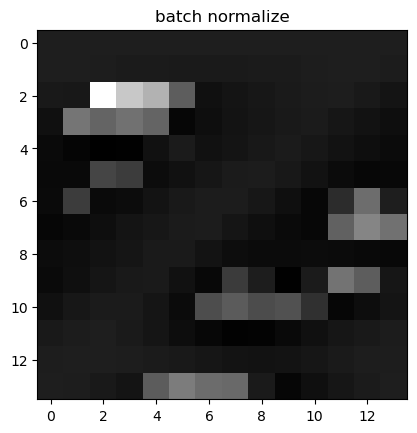

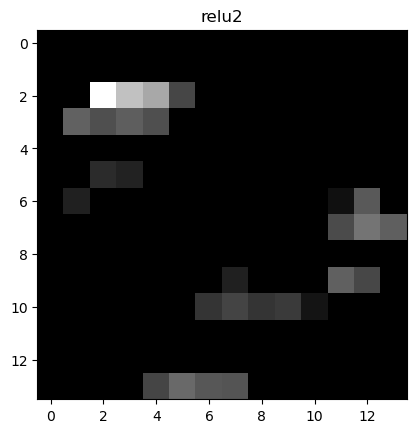

[3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 9, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5, 0, 6, 8, 7, 6, 8, 9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 1, 4, 4, 5, 6, 6, 1, 7, 2, 8, 6, 9, 7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9, 7, 7, 6, 0, 9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7, 9, 9, 6, 7, 3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2, 6, 9, 8, 8, 8, 5, 9, 3, 8, 9, 8, 8, 8, 3, 4, 4, 3, 0, 9, 5, 4, 4, 1, 8, 0, 6, 1, 3, 2, 0, 8, 6, 0, 3, 8, 4, 9, 0, 3, 1, 0, 9, 3, 2, 8, 3, 3, 7, 4, 9, 2, 1, 6, 2, 1, 5, 7, 1, 9, 7, 9, 2, 2, 8, 1, 7, 7, 0, 1, 1, 8, 0, 0, 6, 6, 4, 7, 9, 7, 2, 9, 1, 5, 2, 5, 3, 7, 7, 0, 0, 8, 2, 3, 1, 3, 5, 1, 3, 6, 4, 8, 7, 6, 2, 8, 1, 8, 6, 6, 8, 7, 5, 6, 0, 4, 8, 4, 9, 3, 2, 3, 6, 2, 0, 1, 1, 6, 2, 5, 3, 0, 4, 3, 5, 8, 6, 9, 7, 8, 8, 3, 9, 0, 0, 3, 1, 4, 2, 5, 3, 9, 4, 5, 5, 5, 6, 0, 7, 1, 8, 0, 7, 3, 0, 5, 

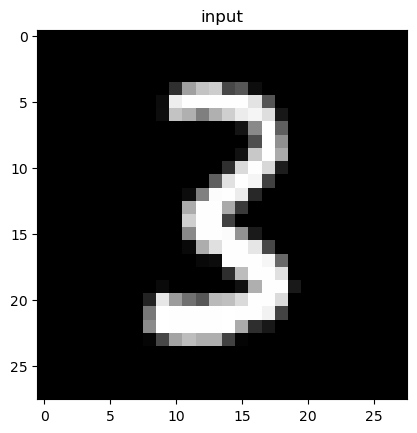

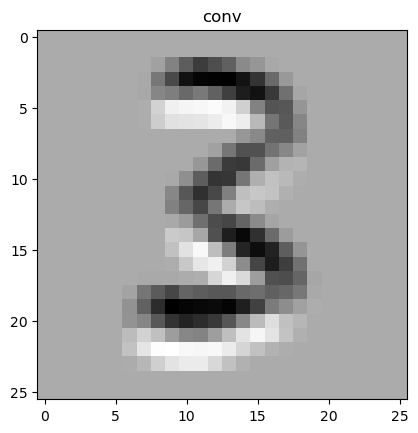

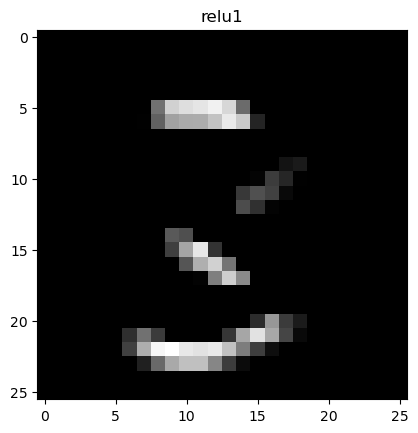

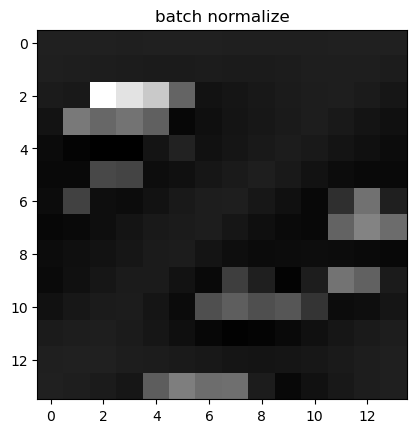

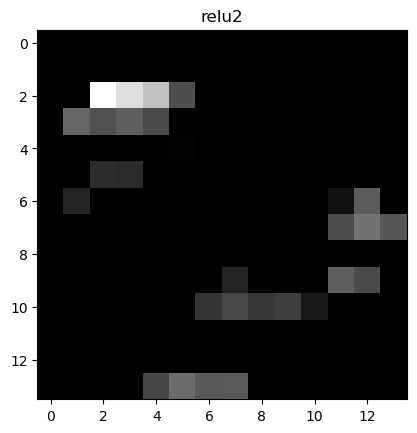

[3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5, 0, 6, 8, 7, 6, 8, 9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 1, 4, 4, 5, 6, 6, 1, 7, 2, 8, 6, 9, 7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9, 7, 7, 6, 0, 9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7, 9, 9, 6, 7, 3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2, 6, 9, 8, 8, 8, 5, 7, 3, 8, 9, 8, 8, 8, 3, 4, 4, 3, 0, 9, 5, 4, 4, 1, 8, 0, 6, 1, 3, 2, 0, 8, 6, 0, 3, 8, 4, 9, 0, 3, 1, 0, 9, 3, 2, 8, 3, 3, 7, 4, 9, 2, 1, 6, 2, 1, 5, 7, 1, 9, 7, 9, 2, 2, 8, 1, 7, 7, 0, 1, 1, 8, 0, 0, 6, 6, 4, 7, 9, 7, 2, 9, 1, 5, 2, 5, 3, 7, 7, 0, 0, 8, 2, 3, 1, 3, 5, 1, 3, 6, 4, 8, 7, 6, 2, 8, 1, 8, 6, 6, 8, 7, 5, 6, 0, 4, 8, 4, 9, 3, 2, 3, 6, 2, 0, 1, 1, 6, 2, 5, 3, 0, 4, 3, 5, 8, 6, 9, 7, 8, 8, 3, 9, 0, 0, 3, 1, 4, 2, 5, 8, 9, 4, 5, 5, 5, 6, 0, 7, 1, 8, 0, 7, 3, 0, 5, 

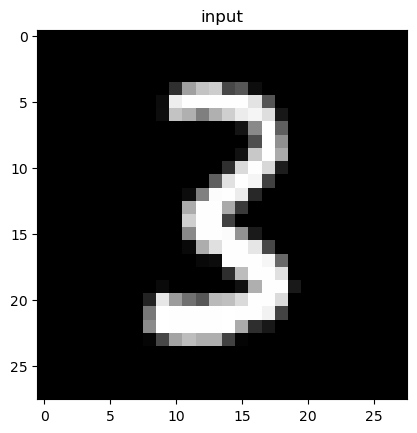

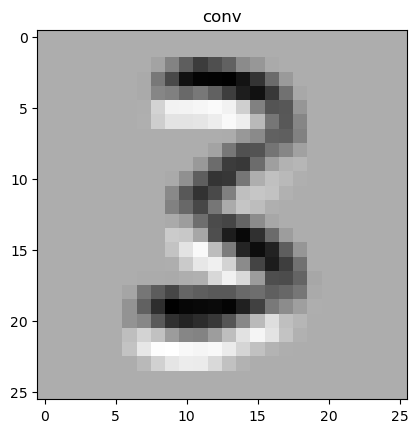

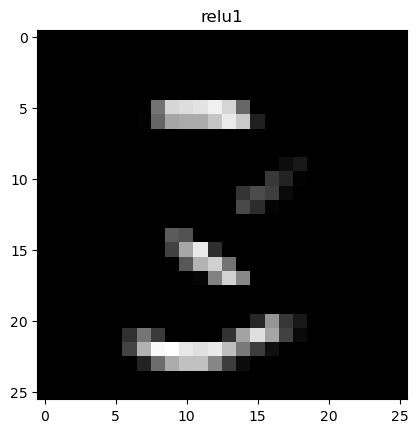

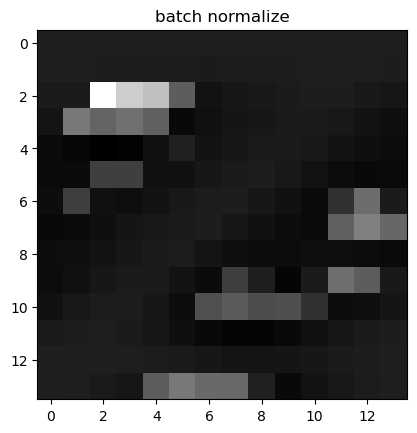

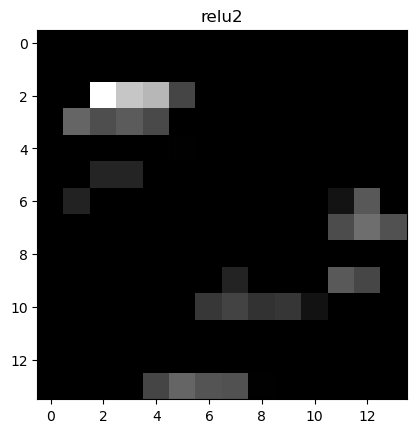

[3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5, 0, 6, 8, 7, 6, 8, 9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 1, 4, 4, 5, 6, 6, 1, 7, 2, 8, 6, 9, 7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9, 7, 7, 6, 0, 9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7, 9, 9, 6, 7, 3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2, 6, 9, 8, 8, 8, 5, 9, 3, 8, 9, 8, 8, 8, 3, 4, 4, 3, 0, 9, 5, 4, 4, 1, 8, 0, 6, 1, 3, 2, 0, 8, 6, 0, 3, 5, 4, 9, 0, 3, 1, 0, 9, 3, 2, 8, 3, 3, 7, 4, 9, 2, 1, 6, 2, 1, 5, 7, 1, 9, 7, 9, 2, 2, 8, 1, 7, 7, 0, 1, 1, 8, 0, 0, 6, 6, 4, 7, 9, 7, 2, 9, 1, 5, 2, 5, 3, 7, 7, 0, 0, 8, 2, 3, 1, 3, 5, 1, 3, 6, 4, 8, 7, 6, 2, 8, 1, 8, 6, 6, 8, 7, 5, 6, 0, 4, 8, 4, 9, 3, 2, 3, 6, 2, 0, 1, 1, 6, 2, 5, 3, 0, 4, 3, 5, 8, 6, 9, 7, 8, 8, 3, 9, 0, 0, 3, 1, 4, 2, 5, 2, 9, 4, 5, 5, 5, 6, 0, 7, 1, 8, 0, 7, 3, 0, 5, 

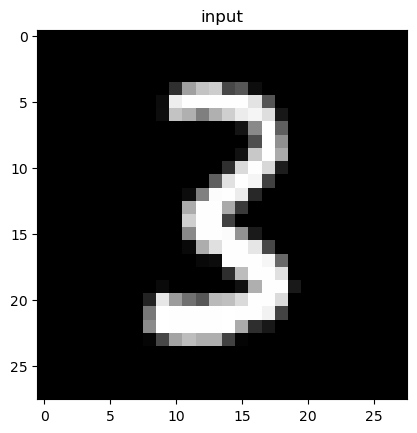

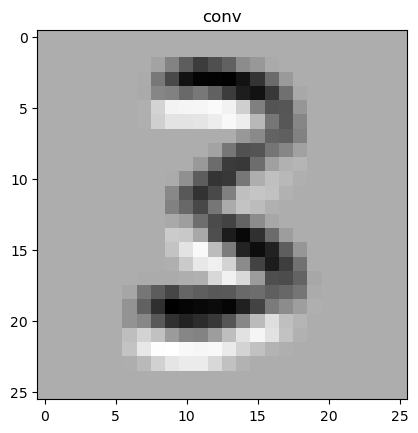

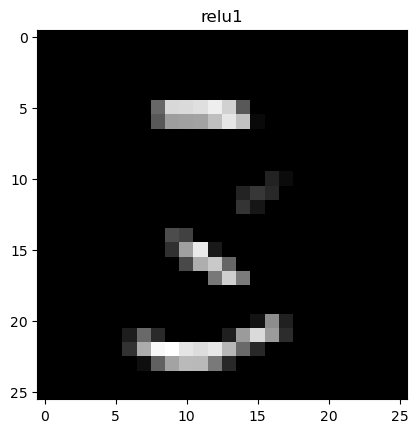

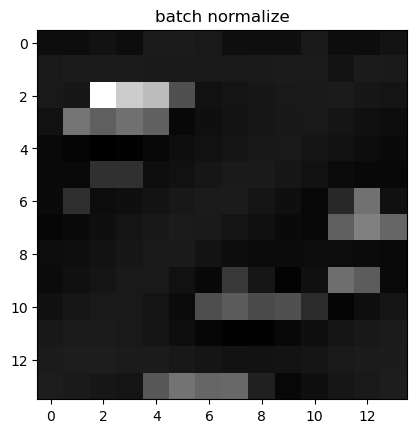

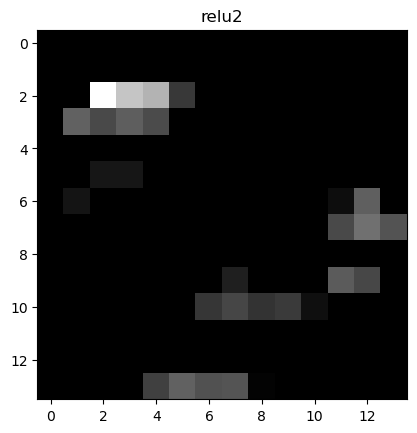

[3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 9, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5, 0, 6, 8, 7, 6, 8, 9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 9, 4, 4, 5, 6, 6, 1, 7, 2, 8, 6, 9, 7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9, 7, 7, 6, 0, 9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7, 9, 9, 6, 7, 3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2, 6, 9, 8, 8, 8, 5, 9, 3, 8, 9, 8, 8, 8, 3, 4, 4, 3, 0, 9, 5, 4, 4, 1, 8, 0, 6, 1, 3, 2, 0, 8, 6, 0, 3, 5, 4, 9, 0, 3, 1, 0, 9, 3, 2, 8, 3, 3, 7, 4, 9, 2, 1, 6, 2, 1, 5, 7, 1, 9, 7, 9, 2, 2, 8, 1, 7, 7, 0, 1, 1, 8, 0, 0, 6, 6, 4, 7, 9, 7, 2, 9, 1, 5, 2, 5, 3, 7, 7, 0, 0, 8, 2, 3, 1, 3, 5, 1, 3, 6, 4, 8, 7, 6, 2, 8, 1, 8, 6, 6, 8, 7, 5, 6, 0, 4, 8, 4, 9, 3, 2, 3, 6, 2, 0, 1, 1, 6, 2, 5, 3, 0, 4, 3, 5, 8, 6, 9, 7, 8, 8, 3, 9, 0, 0, 3, 1, 4, 2, 5, 3, 9, 4, 5, 5, 5, 6, 0, 7, 1, 8, 0, 7, 3, 0, 5, 

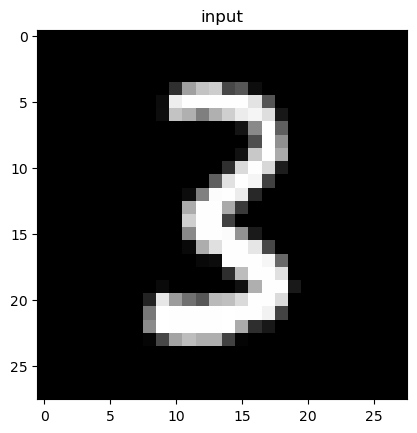

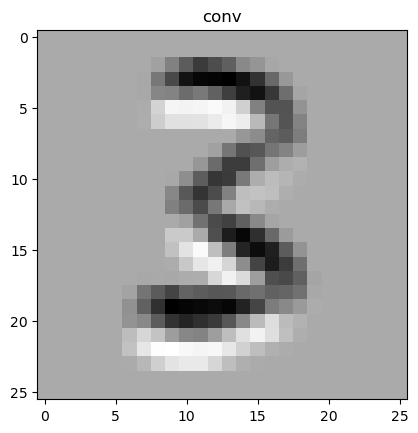

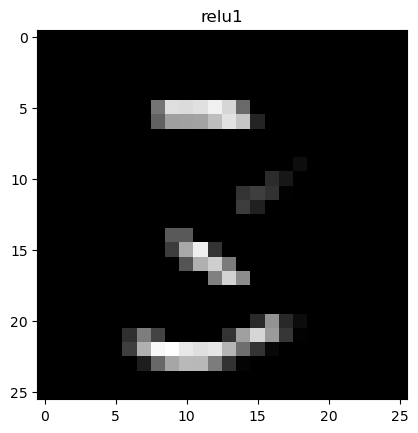

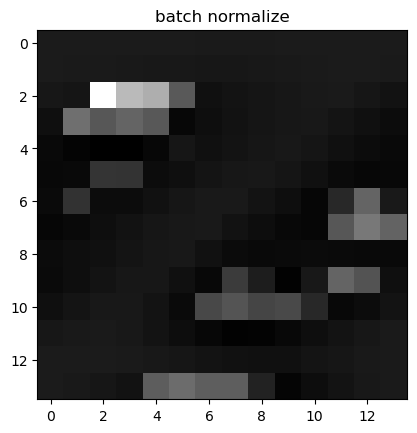

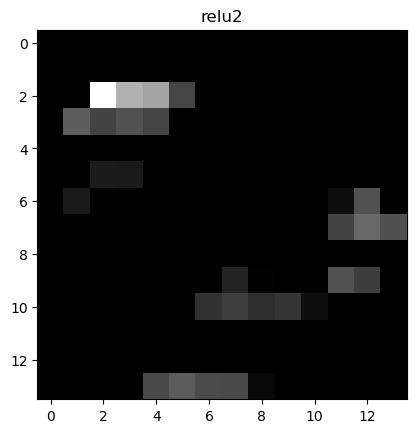

[3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 9, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5, 0, 6, 8, 7, 6, 8, 9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 9, 4, 4, 5, 6, 6, 1, 7, 2, 8, 6, 9, 7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9, 7, 7, 6, 0, 9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7, 9, 9, 6, 7, 3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2, 6, 9, 8, 8, 8, 5, 9, 3, 8, 9, 8, 8, 8, 3, 4, 4, 3, 0, 9, 5, 4, 4, 1, 8, 0, 6, 1, 3, 2, 0, 8, 6, 0, 3, 5, 4, 9, 0, 3, 1, 0, 9, 3, 2, 8, 3, 3, 7, 4, 9, 2, 1, 6, 2, 1, 5, 7, 1, 9, 7, 9, 2, 2, 8, 1, 7, 7, 0, 1, 1, 8, 0, 0, 6, 6, 4, 7, 9, 7, 2, 9, 1, 5, 2, 5, 3, 7, 7, 0, 0, 8, 2, 3, 1, 3, 5, 1, 3, 6, 4, 8, 7, 6, 2, 8, 1, 8, 6, 6, 8, 7, 5, 6, 0, 4, 8, 4, 9, 3, 2, 3, 6, 2, 0, 1, 1, 6, 2, 5, 3, 0, 4, 3, 5, 8, 6, 9, 7, 8, 8, 3, 9, 0, 0, 3, 1, 4, 2, 5, 3, 9, 4, 5, 5, 5, 6, 0, 7, 1, 8, 0, 7, 3, 0, 5, 

In [104]:
#Mnistコンテスト本番ファイル（訓練用）
#畳み込み→活性化→プーリング→バッチ正規化→活性化→全結合→ソフトマックス
#畳み込み層のフィルタサイズは3*3、ストライドは1
#活性化関数には全てReLUを用いる
#プーリングはフィルタサイズ2*2、ストライドは2
#お試し段階では畳み込み→活性化→プーリング→活性化→全結合→ソフトマックス


np.random.seed(0)
#チャンネル数
ch = 1
#畳み込み層のフィルタサイズ
R = 3
#プーリング層のフィルタのサイズ
R_pool = 2
#フィルタの数
K = 8
#畳み込み層のストライド
s = 1
#畳み込み層のパディング
pad = 0
#プーリング層のストライド
s_pool = 2
#バッチ数
batch = 100
#2回目のプーリングが終了した時点でのデータサイズ
d = K * 13 * 13
#クラス数
C = 10
#フィルター行列
# filter_matrix = np.array(np.random.normal(0, 1/np.sqrt(d), (K, R*R*ch)))
filter_matrix = np.array([[1,1,1,0,0,0,-1,-1,-1],[-1,-1,-1,0,0,0,1,1,1],[1,0,-1,1,0,-1,1,0,-1],[-1,0,1,-1,0,1,-1,0,1],[1,0,-1,0,1,0,-1,0,1],[-1,0,1,0,1,0,1,0,-1],[-1,1,-1,1,1,1,-1,1,-1],[1,-1,1,-1,1,-1,1,-1,1]])
#バイアス項
bias_vector = np.array(np.random.normal(0, 1/np.sqrt(d), K))
#全結合層の行列
W_matrix = np.array(np.random.normal(0, 1/np.sqrt(d), (d, C)))
#全結合層のベクトル
b_vector = np.array(np.random.normal(0, 1/np.sqrt(d), C))
#正規化パラメータの初期値
gamma_init = np.ones(d)
beta_init = np.zeros(d)
mean_init = np.zeros(d)
var_init = np.zeros(d)

def mnistcontest_train(batch, W_init, b_init, filter_init, bias_init, gamma, beta, mean_init, var_init):
    #変数を初期化
    W = W_init
    b = b_init
    gamma = gamma_init
    beta = beta_init
    mean_cross_entropy = 0
    mean = np.zeros(d)
    var = np.zeros(d)
    filter_matrix = filter_init
    bias = bias_init
    #バッチ正規化前エポックにおけるバッチの平均と分散
    # mean = mean_init
    # var = var_init
    #学習率
    eta = 0.1
    #イプシロンの値
    epsilon = 1.0e-7
    #ドロップアウト割合
    rho = 0.1
    #0~50000までを重複なく取得
    sampled_data =  np.random.choice(np.arange(0, 50000), size=(int(50000/batch), batch), replace=False)
    i = len(sampled_data)-1
    X_train = X[:, np.newaxis, :, :]
    while(i > 0):
        batch_index = sampled_data[i] 
        #正規化
        batch_matrix = np.array(X_train[batch_index])/255 
        #正解データ
        correct_labels = Y[batch_index] 
        #one-hot
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
        #入力
        input_layer = InputLayer(batch_matrix)
        # plt.imshow(input_layer.output()[0][0], cmap=cm.gray)
        # plt.show()
        # print(f'{input_layer.output()[0][0]=}')
        #畳み込み
        convolution_layer = ConvolutionLayer(input_layer.output(), filter_matrix, bias, batch, R, s, pad)
        # print(f'{convolution_layer.output().shape=}')
        # print(f'{filter_matrix[0]=}')
        # convout = np.array(np.split(convolution_layer.output(), batch, axis=1))
        # convout = convout[0][20].reshape(28, 28)
        # print(f'{convout=}')
        # plt.imshow(convout, cmap=cm.gray)
        # plt.show()
        #活性化1
        activate_layer1 = MiddleLayer(convolution_layer.output(), relu)
        # act1 = np.array(np.split(activate_layer1.output(), batch, axis=1))
        # act1 = act1[0][20].reshape(28, 28)
        # # print(f'{act1=}')
        # plt.imshow(act1, cmap=cm.gray)
        # plt.show()
        # print(activate_layer1.output())
        #ドロップアウト
        # predrop = np.array(np.split(activate_layer1.output(), batch, axis=1))
        # # print(predrop[0])
        # # print(predrop.shape)
        # dropout = Dropout(rho)
        # dropout_forward = dropout.forward(predrop).reshape(K, -1)
        # print(dropout.forward(predrop)[0])
        # print(dropout_forward.shape)
        #プーリング
        pooling_layer = PoolingLayer(activate_layer1.output(), batch, R_pool, s_pool)
        # print(f'{pooling_layer.output().shape}')
        # pool = pooling_layer.output()[0][20]
        # plt.imshow(pool, cmap=cm.gray)
        # plt.show()
        #プーリングした多次元配列を行列の形に整形
        preaffine = pooling_layer.output().reshape(batch, -1).T
        #バッチ正規化
        row_means = np.mean(preaffine, axis=1)
        row_variances = np.var(preaffine, axis=1)
        # if ((mean.all() == 0)&(var.all() == 0)):
        #     mean = row_means
        #     var = row_variances
        # else:
        mean = (1 - eta) * mean + eta * row_means
        var = (1 - eta) * var + eta * row_variances
        stdiv = np.sqrt(row_variances + epsilon)
        x_hat = (preaffine - row_means[:, np.newaxis]) / stdiv[:, np.newaxis]
        normalized_matrix = gamma[:,np.newaxis] * x_hat + beta[:,np.newaxis]
        #活性化2
        activate_layer2 = MiddleLayer(normalized_matrix, relu)
        # act2 = np.array(np.split(activate_layer2.output(), batch, axis=1))
        # act2 = act2[0][20].reshape(28, 28)
        # # print(f'{act1=}')
        # plt.imshow(act1, cmap=cm.gray)
        # plt.show()
        #全結合
        connection_layer = ConnectionLayer(activate_layer2.output(), W, b)
        #ソフトマックス
        output_layer = OutputLayer(connection_layer.output(), softmax) 
        #クロスエントロピー誤差伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
        #全結合層の逆伝播
        errorback_connect = ErrorBackConnect(activate_layer2.output(), errorback_crossentropy.del_en_x(), W)
        #活性化2の誤差逆伝播
        errorback_relu2 = ErrorBackReLU(preaffine, errorback_connect.del_en_x())
        #バッチ正規化層の誤差逆伝播
        errorback_normalize = ErrorBackNormalize(preaffine, x_hat, errorback_relu2.del_en_x(), 
                                                 gamma, beta, epsilon, row_means, row_variances, batch)
        #プーリングの誤差逆伝播
        errorback_pooling = ErrorBackPooling(activate_layer1.output(), pooling_layer.output(), errorback_normalize.del_en_x(), 
                                             K, batch, pooling_layer.max_index(), R_pool, R) 
        #ドロップアウトの誤差逆伝播
        # prebackdrop = np.array(np.split(errorback_pooling.del_en_x(), batch, axis=1))
        # errorback_dropout = dropout.backward(prebackdrop).reshape(K, -1)
        #活性化層1の誤差逆伝播
        errorback_relu1 = ErrorBackReLU(convolution_layer.output(), errorback_pooling.del_en_x())
        #畳み込み層の誤差逆伝播
        errorback_convolution = ErrorBackConvolution(convolution_layer.rerange(), errorback_relu1.del_en_x(), filter_matrix)
        #変数を更新
        W = W - eta * errorback_connect.del_en_w().T
        b = b - eta * errorback_connect.del_en_b()
        gamma = gamma - eta * errorback_normalize.del_en_gamma()
        beta = beta - eta * errorback_normalize.del_en_beta()
        filter_matrix = filter_matrix - eta * errorback_convolution.del_en_w()
        bias = bias - eta * errorback_convolution.del_en_b()
        i -= 1
        # print(W)
        # print(b)
        # print(f'{filter_matrix[10]=}')
        # print(f'{bias=}')
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        # print(crossentropy.result())
        if(i==0):
            # test_mean = mean_mean / len(sampled_data)
            # test_var = mean_var / len(sampled_data)
            # print("バッチ平均:" + str(test_mean))
            # print("バッチ分散:" + str(test_var))
            # test_mean = (test_mean + mean)/2
            # test_var = (test_var + var)/2
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/W", W)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/b", b)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/gamma", gamma)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/beta", beta)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/test_mean", mean)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/test_var", var)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/filter_matrix", filter_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/bias", bias)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_matrix = X_train[50000:]
            testbatch, k, dx, dy = test_matrix.shape
            #正規化
            test_matrix = np.array(test_matrix) / 255
            answer_labels = Y[50000:]
            #入力層
            test_input_layer = InputLayer(test_matrix)
            plt.imshow(test_input_layer.output()[0][0], cmap=cm.gray)
            plt.title('input')
            plt.show()
            #畳み込み
            test_convolution_layer = ConvolutionLayer(test_input_layer.output(), filter_matrix, bias, testbatch, R, s, pad)
            convout = np.array(np.split(test_convolution_layer.output(), testbatch, axis=1))
            convout = convout[0][0].reshape(26, 26)
            plt.imshow(convout, cmap=cm.gray)
            plt.title('conv')
            plt.show()
            #活性化1
            test_activate_layer1 = MiddleLayer(test_convolution_layer.output(), relu)
            act1 = np.array(np.split(test_activate_layer1.output(), testbatch, axis=1))
            act1 = act1[0][0].reshape(26, 26)
            plt.imshow(act1, cmap=cm.gray)
            plt.title('relu1')
            plt.show()
            #ドロップアウト
            #プーリング
            test_pooling_layer = PoolingLayer(test_activate_layer1.output(), testbatch, R_pool, s_pool)
            #行列に整形、正規化
            var = (batch / (batch - 1))*var 
            test_preaffine = test_pooling_layer.output().reshape(testbatch, -1).T
            e1 = (gamma / np.sqrt(var + epsilon))[:,np.newaxis] * test_preaffine
            e2 = beta - gamma * mean / np.sqrt(var + epsilon)
            normalized_output = e1 + e2[:,np.newaxis]
            norm = normalized_output.T[0][0:13*13].reshape(13, 13)
            plt.imshow(norm, cmap=cm.gray)
            plt.title('batch normalize')
            plt.show()
            #活性化2
            test_activate_layer2 = MiddleLayer(normalized_output, relu)
            act2 = MiddleLayer(norm, relu)
            plt.imshow(act2.output(), cmap=cm.gray)
            plt.title('relu2')
            plt.show()
            #画像の描写
            
            #全結合
            test_connection_layer = ConnectionLayer(test_activate_layer2.output(), W, b)
            #ソフトマックス
            output_layer_test = OutputLayer(test_connection_layer.output(), softmax)
            print(np.argmax(output_layer_test.output(), axis=0).tolist())
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer_test.output(), axis=0).tolist(), answer_labels)))
            # print(np.argmax(output_layer_test.output(), axis=0))
            

            
mnistcontest_train(100, W_matrix, b_vector, filter_matrix, bias_vector, gamma_init, beta_init, mean_init, var_init)
j = 8
while(j > 0):
    W = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/W.npy")
    b = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/b.npy")
    gamma = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/gamma.npy")
    beta = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/beta.npy")
    filter_init = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/filter_matrix.npy")
    bias = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/bias.npy")
    mean = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/test_mean.npy")
    var = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/test_var.npy")
    mnistcontest_train(100, W, b, filter_init, bias, gamma, beta, mean, var)
    j -= 1
    print("epoch残り"+str(j))

In [77]:
import numpy as np
#ファイルの読み込み
with open("le4MNIST_X (1).txt", "r") as file:
    file_contents = file.read().splitlines()

data_list = []
data_list2 = []
for item in file_contents:
    numbers = [int(num) for num in item.split()]
    reshaped_data = np.array(numbers, dtype=int).reshape(1, 28, 28)
    data_list.append(reshaped_data)
    data_list2.append(np.array(numbers))
final_data = np.array(data_list)
final_data2 = np.array(data_list2).T
print(final_data2.shape)

(784, 10000)


テスト開始


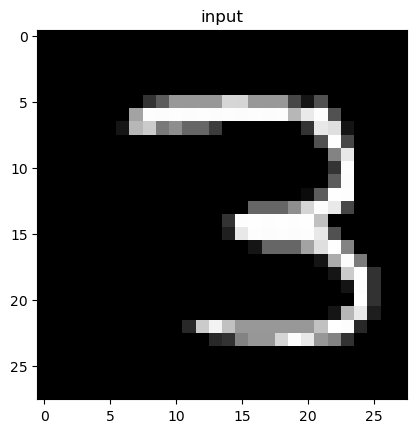

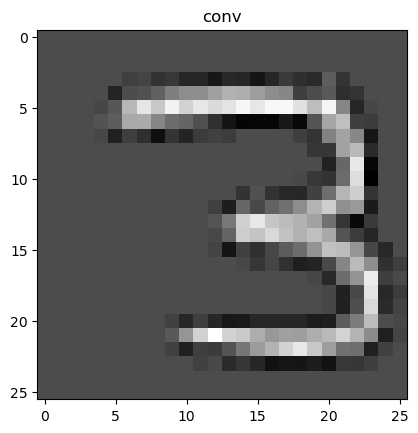

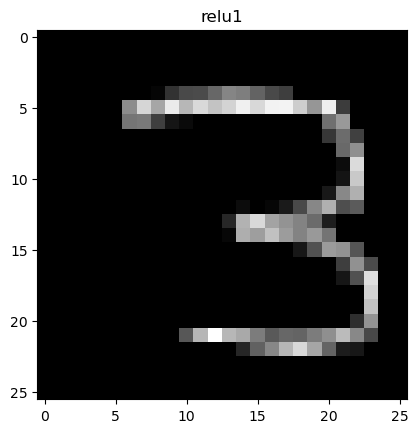

バッチ平均:[0.         0.00010555 0.00032081 ... 0.02354736 0.00700196 0.0012923 ]
バッチ分散:[0.00000000e+00 6.22674671e-05 4.07262068e-04 ... 1.68046141e-02
 4.77011900e-03 7.79208458e-04]


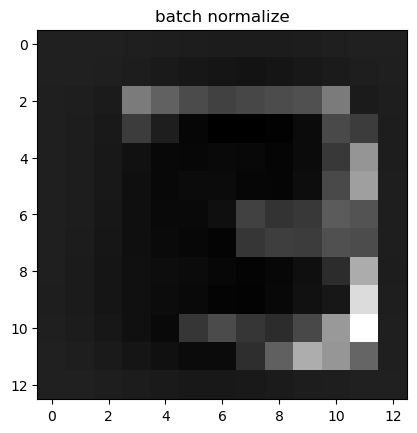

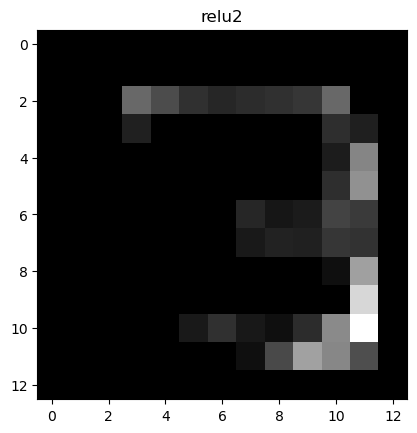

2
[9, 0, 6, 5, 7, 5, 2, 4, 7, 7, 7, 4, 7, 6, 5, 0, 6, 1, 6, 4, 2, 9, 4, 7, 2, 0, 8, 5, 1, 1, 5, 9, 4, 1, 4, 2, 7, 8, 5, 5, 0, 5, 8, 5, 4, 3, 8, 8, 0, 1, 3, 6, 5, 1, 4, 2, 2, 7, 3, 7, 6, 6, 5, 9, 5, 0, 7, 4, 7, 2, 1, 7, 1, 4, 7, 1, 4, 6, 4, 2, 1, 7, 4, 0, 2, 6, 9, 3, 7, 0, 8, 2, 4, 5, 7, 0, 1, 3, 7, 1, 1, 0, 7, 2, 1, 7, 8, 0, 2, 1, 6, 5, 8, 4, 7, 7, 7, 2, 2, 6, 1, 2, 3, 0, 8, 2, 4, 8, 0, 8, 5, 1, 3, 6, 5, 2, 9, 3, 6, 7, 9, 8, 0, 8, 5, 2, 6, 6, 1, 8, 3, 1, 6, 4, 5, 5, 5, 4, 9, 0, 7, 8, 6, 8, 5, 4, 8, 5, 8, 6, 8, 3, 7, 9, 7, 6, 5, 0, 2, 2, 0, 4, 4, 4, 0, 8, 0, 6, 1, 2, 1, 6, 6, 2, 4, 8, 5, 7, 5, 6, 1, 6, 0, 8, 4, 8, 6, 5, 5, 8, 2, 1, 6, 3, 7, 2, 3, 8, 3, 3, 7, 7, 4, 0, 1, 7, 3, 9, 3, 2, 5, 1, 1, 8, 8, 8, 2, 7, 4, 6, 8, 7, 2, 8, 3, 2, 2, 4, 4, 7, 3, 7, 9, 2, 2, 8, 5, 0, 6, 8, 9, 0, 4, 5, 2, 3, 4, 4, 1, 2, 9, 1, 3, 1, 9, 9, 6, 7, 0, 7, 4, 4, 3, 9, 9, 1, 5, 7, 4, 3, 8, 5, 5, 0, 2, 5, 2, 0, 3, 6, 0, 6, 1, 2, 6, 1, 9, 4, 6, 6, 2, 4, 1, 3, 0, 6, 7, 7, 1, 9, 8, 2, 5, 0, 5, 9, 4, 2, 5, 4, 0, 8, 8

In [278]:
#### Mnistコンテスト本番ファイル（テスト用）
# mnist_contest(test_data, W, b, filter_matrix, bias):
#入力のテストデータはこの時点でbatch*ch*dx*dyの形状にしておく
n = 135#バッチの番号
i = 6 #フィルターの番号
def mnist_contest(test_data, W, b, filter_matrix, bias, gamma, beta, mean, var):
    epsilon = 1.0e-7
    batch, ch, dx, dy = test_data.shape
    #正規化
    test_data = test_data/255
    #入力層
    input_layer = InputLayer(test_data)
    plt.imshow(input_layer.output()[n][0], cmap=cm.gray)
    plt.title('input')
    plt.show()
    #畳み込み層
    convolution_layer = ConvolutionLayer(input_layer.output(), filter_matrix, bias, batch, R, s, pad)
    convout = np.array(np.split(convolution_layer.output(), batch, axis=1))
    convout = convout[n][i].reshape(26, 26)
    plt.imshow(convout, cmap=cm.gray)
    plt.title('conv')
    plt.show()
    #活性化1
    activate_layer1 = MiddleLayer(convolution_layer.output(), relu)
    act1 = np.array(np.split(activate_layer1.output(), batch, axis=1))
    act1 = act1[n][i].reshape(26, 26)
    plt.imshow(act1, cmap=cm.gray)
    plt.title('relu1')
    plt.show()
    #プーリング
    pooling_layer=PoolingLayer(activate_layer1.output(),batch,R_pool,s_pool)
    #行列に整形、正規化
    #不偏分散を考える
    var = (100/99)*var
    preaffine = pooling_layer.output().reshape(batch, -1).T
    row_means = np.mean(preaffine, axis=1)
    # mean_mean += row_means
    row_variances = np.var(preaffine, axis=1)
    print("バッチ平均:" + str(row_means))
    print("バッチ分散:" + str(row_variances))
    e1 = (gamma / np.sqrt(var + epsilon))[:,np.newaxis] * preaffine
    e2 = beta - gamma * mean / np.sqrt(var + epsilon)
    normalized_output = e1 + e2[:,np.newaxis]
    norm = normalized_output.T[n][13*13*i:13*13*(i+1)].reshape(13, 13)
    plt.imshow(norm, cmap=cm.gray)
    plt.title('batch normalize')
    plt.show()
    # #活性化2
    activate_layer2 = MiddleLayer(normalized_output, relu)
    # act2 = MiddleLayer(norm, relu)
    act2 = activate_layer2.output().T[n][13*13*i:13*13*(i+1)].reshape(13, 13)
    plt.imshow(act2, cmap=cm.gray)
    plt.title('relu2')
    plt.show()
    #全結合
    connection_layer = ConnectionLayer(activate_layer2.output(), W, b)
    #ソフトマックス
    output_layer = OutputLayer(connection_layer.output(), softmax)
    # print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))
    print(np.argmax(output_layer.output(), axis=0).tolist()[n])
    print(np.argmax(output_layer.output(), axis=0).tolist())
    with open("predict.txt", "w") as file:
        for item in np.argmax(output_layer.output(), axis=0).tolist():
            file.write(str(item)+"\n")

W = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/W.npy")
b = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/b.npy")
gamma = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/gamma.npy")
beta = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/beta.npy")
filter_init = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/filter_matrix.npy")
bias = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/bias.npy")
mean = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/test_mean.npy")
var = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/test_var.npy")
print("テスト開始")
test_data = final_data
mnist_contest(test_data, W, b, filter_init,bias, gamma, beta, mean, var)

In [7]:
#Mnistコンテスト、畳み込みなし
# 学習モデルは3NN、バッチ正規化を全結合層1と中間層の間で行う。
# 中間層の活性化関数にはシグモイド関数を用いる
def mnist_contest_noconv(test_data, w1, b1, w2, b2, gamma, beta, mean, var):
    # イプシロンの値
    epsilon = 0.001
    # batch, ch, dx, dy = test_data.shape
    #正規化
    test_data = test_data/255
    #入力層
    input_layer = InputLayer(test_data)
    #全結合層1
    connection1_layer = ConnectionLayer(input_layer.output(), w1, b1)
    #正規化
    e1 = (gamma / np.sqrt(var + epsilon))[:,np.newaxis] * connection1_layer.output()
    e2 = beta - gamma * mean / np.sqrt(var + epsilon)
    normalized_output = e1 + e2[:,np.newaxis]
    #中間層
    middle_layer = MiddleLayer(normalized_output, sigmoid)
    #全結合層2
    connection2_layer = ConnectionLayer(middle_layer.output(), w2, b2)
    #出力層
    output_layer = OutputLayer(connection2_layer.output(), softmax)
    print(np.argmax(output_layer.output(), axis=0).tolist())
    with open("predict.txt", "w") as file:
        for item in np.argmax(output_layer.output(), axis=0).tolist():
            file.write(str(item))
    
w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/w1.npy')
b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/b1.npy')
w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/w2.npy')
b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/b2.npy')
gamma = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/gamma.npy')
beta = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/beta.npy')
test_mean = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/test_mean.npy')
test_var = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/test_var.npy')
print("テスト開始します")
mnist_contest_noconv(final_data2,w1, b1, w2, b2, gamma, beta, test_mean, test_var)

テスト開始します
[9, 5, 6, 5, 7, 5, 2, 5, 7, 7, 7, 9, 7, 3, 5, 0, 6, 1, 6, 4, 2, 9, 4, 3, 9, 0, 3, 0, 9, 7, 5, 9, 4, 8, 4, 2, 7, 8, 5, 5, 5, 5, 5, 8, 4, 3, 8, 8, 0, 8, 3, 6, 5, 0, 4, 2, 8, 7, 3, 7, 2, 6, 5, 9, 5, 0, 7, 4, 7, 2, 7, 8, 1, 3, 9, 1, 4, 2, 7, 3, 8, 7, 4, 7, 2, 4, 9, 0, 7, 2, 6, 3, 4, 7, 7, 0, 1, 3, 4, 1, 4, 5, 7, 2, 1, 9, 8, 2, 2, 3, 6, 5, 8, 8, 7, 7, 7, 2, 2, 6, 9, 3, 9, 0, 5, 2, 4, 8, 5, 2, 5, 6, 6, 6, 6, 2, 2, 3, 6, 7, 9, 8, 5, 7, 5, 2, 6, 6, 8, 5, 3, 1, 2, 5, 8, 3, 5, 4, 6, 2, 7, 5, 6, 4, 0, 4, 8, 5, 5, 6, 5, 3, 7, 9, 5, 3, 5, 0, 2, 9, 0, 4, 4, 5, 0, 5, 0, 6, 1, 2, 3, 3, 0, 3, 4, 8, 3, 7, 5, 5, 3, 6, 0, 8, 5, 7, 6, 5, 5, 3, 3, 2, 6, 3, 7, 2, 6, 6, 3, 3, 7, 2, 4, 2, 1, 7, 3, 3, 8, 5, 5, 7, 2, 3, 8, 8, 5, 7, 4, 6, 8, 7, 2, 3, 5, 3, 7, 4, 4, 7, 3, 6, 8, 2, 7, 9, 5, 0, 6, 8, 9, 0, 5, 5, 2, 3, 6, 4, 1, 2, 9, 5, 3, 9, 7, 9, 5, 7, 0, 3, 3, 4, 5, 9, 9, 3, 5, 7, 3, 3, 5, 5, 5, 0, 8, 5, 3, 2, 3, 3, 0, 6, 5, 9, 6, 4, 3, 4, 6, 3, 4, 3, 1, 3, 0, 6, 7, 2, 3, 9, 7, 2, 5, 0, 9, 9, 4, 3, 5, 4, 

0~9999の数字を入力 1


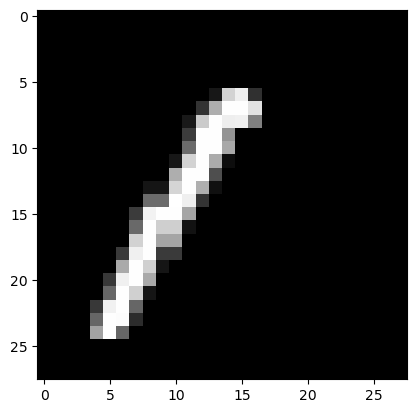

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  23 212 239  48   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  51 174 254 254 226   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  25 203 254 238 24

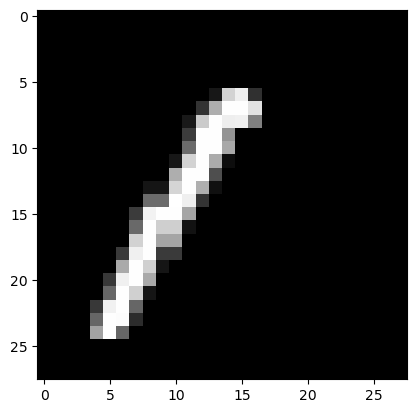

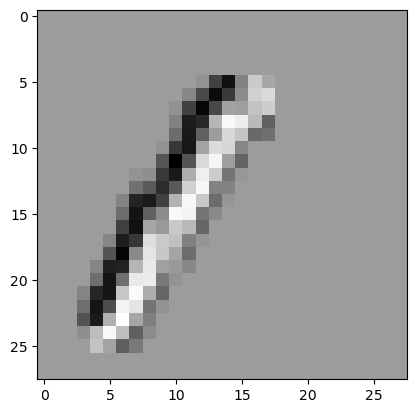

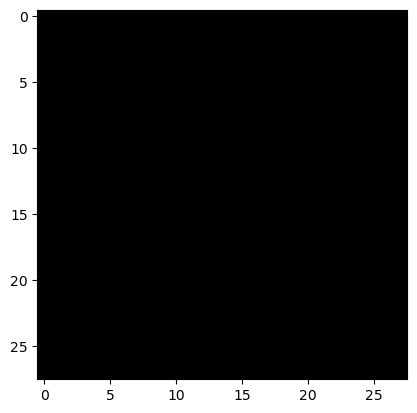

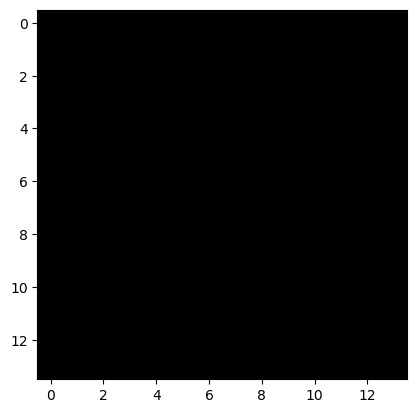

ValueError: operands could not be broadcast together with shapes (10,5880) (10,) 

In [89]:
#MNISTコンテスト畳み込み、畳み込み、プーリングの様子を見るため
def cnn_demo(data, W, b, filter_matrix, bias, gamma, beta, mean, var):
    #みたいフィルター番号
    j = 13
    #諸々の定数
    rho = 0.1
    epsilon = 1e-7
    #最初の画像
    plt.imshow(data[0], cmap=cm.gray)
    plt.show()
    print(data[0])
    #最初の正規化
    data = data/255
    print(data[0])
    plt.imshow(data[0], cmap=cm.gray)
    plt.show()
    data = data.reshape(1, 1, 28, 28)
    #畳み込み
    conv = ConvolutionLayer(data, filter_matrix, bias, 1, R, s)
    # print(conv.output()[0].shape)
    convout = conv.output()[j].reshape(28, 28)
    plt.imshow(convout, cmap=cm.gray)
    plt.show()
    # print(convout)
    #活性化
    active1 = MiddleLayer(conv.output(), relu)
    plt.imshow(active1.output()[j].reshape(28, 28), cmap=cm.gray)
    plt.show()
    #ドロップアウトテスト、プーリング
    pooling_layer=PoolingLayer(active1.output(),1,R_pool,s_pool)
    # print((1-rho)*active1.output()[0])
    # print(pooling_layer.output().shape)
    # poolout = pooling_layer.output().reshape(14, 14)
    # print(pooling_layer.output()[0][5])
    plt.imshow(pooling_layer.output()[0][5], cmap=cm.gray)
    plt.show()
    #行列に整形、正規化
    preaffine = pooling_layer.output().reshape(1, -1).T
    e1 = (gamma / np.sqrt(var + epsilon)) * preaffine
    e2 = beta - gamma * mean / np.sqrt(var + epsilon)
    normalized_output = e1 + e2
    #活性化2
    activate_layer2 = MiddleLayer(normalized_output, relu)
    #全結合
    connection_layer = ConnectionLayer(activate_layer2.output(), W, b)
    #ソフトマックス
    output_layer = OutputLayer(connection_layer.test_output(), softmax)
    result = np.argmax(output_layer.output())
    print("予測結果" + str(result))
    
W = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/W.npy")
b = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/b.npy")
gamma = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/gamma.npy")
beta = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/beta.npy")
filter_init = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/filter_matrix.npy")
bias = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/bias.npy")
mean = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/test_mean.npy")
var = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_test/test_var.npy")
i = int(input("0~9999の数字を入力"))
test_data = final_data[i]
cnn_demo(test_data, W, b, filter_matrix,bias, gamma, beta, mean, var)